# Homework 2

Agata Kaczmarek

Implement CNN classification model and test it on [CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html) data set.

Later:

* compare results on train and test data set for ResNet (18 and 34)
* show ideas how to deal with overfitting problem using eg Droupout method
* visualize confusion matrix and show images, where there was a misclassification

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.datasets as torch_data
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

import os
import argparse


import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import json
from IPython.display import clear_output
import random

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [3]:
if torch.cuda.is_available():  
  DEVICE = "cuda:0" 
else:  
  DEVICE = "cpu" 

### Model

Implementation was presented during labs, source of the code: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py.

In [4]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385

Source of the model: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
'''


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


I will use only ResNet18 and ResNet34, as they are learning faster and their results are satisfactory enough for experiments conducted below.

In [5]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

### Data

Download dataset. Below I also take the subsample (10%) of whole data set - training and testing will be much faster. Subsample is generated randomly every time I download the set.

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size_train=128
batch_size_test=100

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_sample_index = [random.randint(0,50000) for i in range (5000)]
trainset_1 = torch.utils.data.Subset(trainset, train_sample_index)
trainloader = torch.utils.data.DataLoader(
    trainset_1, batch_size=batch_size_train, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_sample_index = [random.randint(0,10000) for i in range (1000)]
testset_1 = torch.utils.data.Subset(testset, test_sample_index)
testloader = torch.utils.data.DataLoader(
    testset_1, batch_size=batch_size_test, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's see how our data look like, some examples of it.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])
torch.Size([128])
cat   car   ship  frog  bird  ship  cat   bird  bird  ship  bird  frog  dog   plane plane frog  bird  truck horse truck car   truck horse plane horse deer  plane horse ship  horse ship  ship  truck frog  dog   dog   horse bird  car   car   plane horse ship  plane car   truck bird  plane truck ship  bird  deer  plane frog  cat   truck plane frog  dog   truck plane frog  car   deer  horse cat   deer  bird  dog   bird  ship  truck car   plane plane car   horse ship  ship  horse bird  cat   car   car   deer  cat   truck ship  horse bird  deer  plane deer  bird  ship  dog   car   horse horse dog   bird  frog  frog  truck bird  cat   plane deer  cat   plane car   dog   car   bird  plane horse frog  horse plane truck horse cat   frog  truck cat   plane horse truck


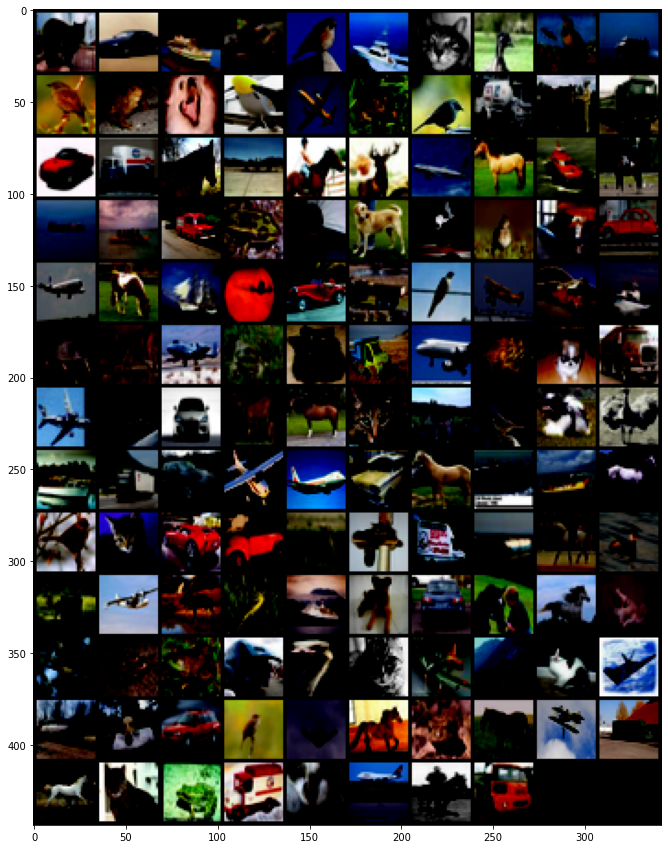

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size_train)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])
torch.Size([100])
truck ship  ship  frog  cat   truck cat   bird  ship  car   frog  plane cat   car   deer  dog   deer  plane cat   deer  frog  plane deer  dog   dog   plane deer  truck horse ship  frog  bird  horse dog   frog  cat   horse plane horse truck bird  bird  plane ship  plane frog  plane truck car   dog   ship  car   deer  truck deer  frog  horse cat   plane car   horse plane truck deer  dog   dog   plane ship  car   car   truck plane car   ship  car   bird  cat   plane dog   dog   deer  plane car   ship  truck frog  plane car   car   dog   dog   ship  car   dog   truck cat   plane car   horse horse


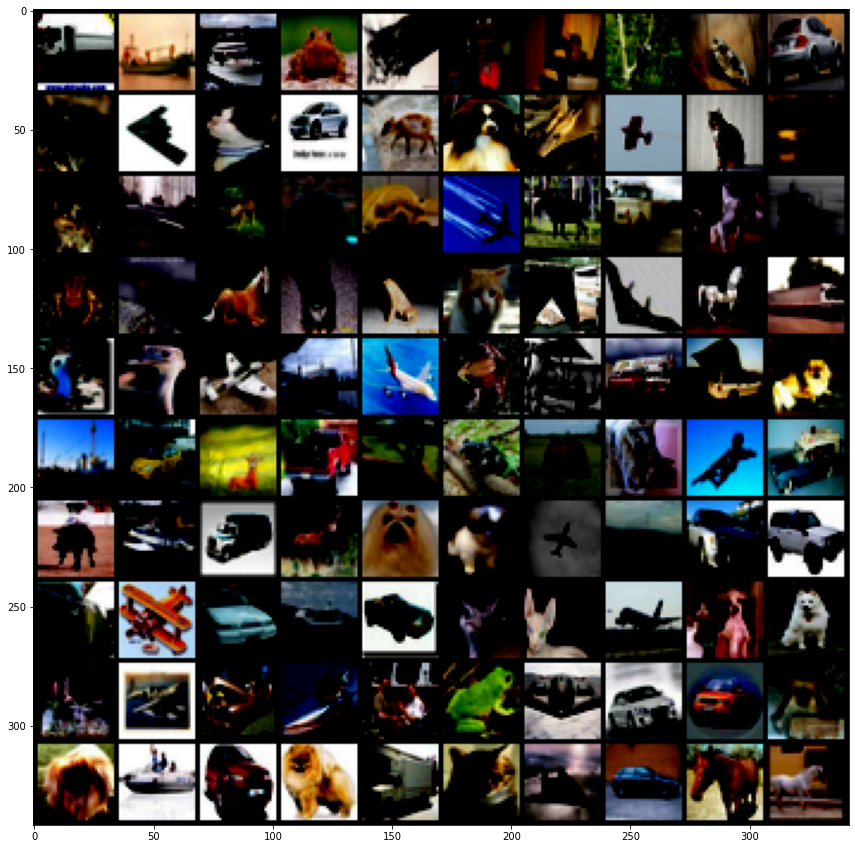

In [8]:
dataiter_test = iter(testloader)
images_test, labels_test = dataiter_test.next()

print(images_test.shape)
print(labels_test.shape)
grid_test = torchvision.utils.make_grid(images_test, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(grid_test.permute(1,2,0))

print(' '.join(f'{classes[labels_test[j]]:5s}' for j in range(batch_size_test)))

In general both train and test datasets look good, optically in most of the cases I can see in which class the images should belong to - like is it a cat or a plane. However, in some cases I have to say, that I also have some problems with saying what is there, so I won't be surprised, if the model also does not know it :)

### Training ResNet18

I will start with training some example of ResNet18 with some randomly chosen values of learning rate, momentum and number of epochs. It is just to see, what are the changes between accuracy in subsequent epochs. Later I will search for optimal parameters.

In [10]:
net18=ResNet18()
net18=net18.to(DEVICE)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net18.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


In [21]:
#for manually starting training and testing
def train(epoch,net, trainloader):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

def test(epoch,net, testloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    return acc, targets, predicted, inputs

### Results of a model

In [22]:
# training and testing of ResNet18
start_epoch=1
acc18_test=[]
for epoch in range(start_epoch, start_epoch+20):
    train(epoch,net18, trainloader)
    acc,targets_18,predicted_18, inputs_18=test(epoch,net18,testloader)
    acc18_test.append(acc)
    scheduler.step()


Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19

Epoch: 20


In [23]:
print(acc18_test)

[47.4, 42.6, 45.1, 44.4, 45.4, 48.6, 49.3, 48.3, 44.6, 46.9, 42.2, 47.2, 46.9, 48.1, 47.6, 49.1, 48.1, 49.4, 48.0, 48.6]


In [20]:
PATH = './cifar_net_new.pth'
torch.save(net18.state_dict(), PATH)

It seems, that this model is learning, the results are quite ok, as this dataset consists of 10 various classes. Below I train ResNet34 to compare the results between those two nets.

Training ResNet34

In [ ]:
net34=ResNet34()
net34=net34.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net34.parameters(), lr=0.0001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


In [ ]:
start_epoch=1
acc34=[]
for epoch in range(start_epoch, start_epoch+50):
    train(epoch,net34, trainloader)
    acc,targets_34,predicted_34, inputs_34=test(epoch,net34,testloader)
    acc34.append(acc)
    scheduler.step()


Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19

Epoch: 20

Epoch: 21

Epoch: 22

Epoch: 23

Epoch: 24

Epoch: 25

Epoch: 26

Epoch: 27

Epoch: 28

Epoch: 29

Epoch: 30

Epoch: 31

Epoch: 32

Epoch: 33

Epoch: 34

Epoch: 35

Epoch: 36

Epoch: 37

Epoch: 38

Epoch: 39

Epoch: 40

Epoch: 41

Epoch: 42

Epoch: 43

Epoch: 44

Epoch: 45

Epoch: 46

Epoch: 47

Epoch: 48

Epoch: 49

Epoch: 50


In [ ]:
print(acc34)

[46.3, 47.55, 48.36666666666667, 46.766666666666666, 48.45, 48.46666666666667, 47.43333333333333, 50.13333333333333, 50.31666666666667, 50.18333333333333, 49.733333333333334, 50.53333333333333, 50.43333333333333, 51.96666666666667, 49.1, 51.81666666666667, 51.666666666666664, 51.983333333333334, 53.18333333333333, 53.483333333333334, 53.71666666666667, 53.416666666666664, 53.733333333333334, 54.1, 54.53333333333333, 54.166666666666664, 54.95, 53.71666666666667, 55.31666666666667, 55.7, 55.65, 55.583333333333336, 55.583333333333336, 56.3, 55.5, 56.15, 55.43333333333333, 56.583333333333336, 57.06666666666667, 56.88333333333333, 57.93333333333333, 56.96666666666667, 56.9, 57.93333333333333, 57.5, 57.833333333333336, 57.0, 58.666666666666664, 57.88333333333333, 58.266666666666666]


This net seems to be learning all the time, accuracy on testing set is increasing. However we can see, that ResNet18 learned faster than ResNet34 (when comparing with the same number of epochs of course). Here I trained ResNet18 only on 20 epochs and ResNet34, as second one was more promising, but also ResNet18 was trained before on 50 epochs, but there were some issues with GPU on Colab, so I did not update this traning after updating code - later we will see, that ResNet18 stops learning on about 10/20 epoch, so it didn't make sense to do it on 50 epochs once again.

### Search for optimal parameters

Using code presented during labs. However I added calculating accuracy for test set, to be able to compare accuracy for both train and test set, to try to identify possible cases, where model is overfitted.

In [ ]:
# import modules to build RunBuilder and RunManager helper classes
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_num_correct_test = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.loader_test = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader, loader_test):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.loader_test = loader_test
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images.to(DEVICE))

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images.to(DEVICE))

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

    self.epoch_loss_test = 0
    self.epoch_num_correct_test = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)
    accuracy_test = self.epoch_num_correct_test / len(self.loader_test.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    self.tb.add_scalar('Accuracy_test', accuracy_test, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["accuracy_test"] = accuracy_test
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  def track_num_correct_test(self, preds, labels):
    self.epoch_num_correct_test += self._get_num_correct_test(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

  def _get_num_correct_test(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [ ]:
def search(parameters, model, fileName, epochs):
  m = RunManager()

  # get all runs from params using RunBuilder class
  for run in RunBuilder.get_runs(parameters):

      # if params changes, following line of code should reflect the changes too
      network = model().to(DEVICE)
      loader = torch.utils.data.DataLoader(trainset_1, batch_size = run.batch_size)
      loader_test = torch.utils.data.DataLoader(testset_1, batch_size = run.batch_size)
      optimizer = optim.Adam(network.parameters(), lr=run.lr)

      m.begin_run(run, network, loader, loader_test)
      for epoch in range(epochs):
        
        m.begin_epoch()

        for batch in loader_test:
          images = batch[0].to(DEVICE)
          labels = batch[1].to(DEVICE)
          preds = network(images)
          m.track_num_correct_test(preds, labels)

        for batch in loader:
          
          images = batch[0].to(DEVICE)
          labels = batch[1].to(DEVICE)
          preds = network(images)
          loss = F.cross_entropy(preds, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          m.track_loss(loss)
          m.track_num_correct(preds, labels)

        m.end_epoch()
      m.end_run()

  # when all runs are done, save results to files
  m.save(fileName)

In [ ]:
ResNet18

In [ ]:
#begin of a search for ResNet18

from collections  import OrderedDict
parameters = OrderedDict(
    lr = [.01, .001],
    batch_size = [10, 40],
    shuffle = [True]
)
epochs = 10
search(parameters, ResNet18, 'results_net18', epochs)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,2.306235,0.1692,0.083,34.357210,34.879521,0.010,10,True
1,1,2,1.999385,0.2508,0.217,34.836780,72.419469,0.010,10,True
2,1,3,1.813531,0.3168,0.306,34.294773,109.399810,0.010,10,True
3,1,4,1.685759,0.3752,0.355,34.448447,146.573196,0.010,10,True
4,1,5,1.570395,0.4242,0.381,34.348783,183.519863,0.010,10,True
5,1,6,1.443102,0.4712,0.425,34.505681,220.636765,0.010,10,True
6,1,7,1.285669,0.5342,0.440,34.387190,257.702758,0.010,10,True
7,1,8,1.081781,0.6088,0.457,34.441451,294.799982,0.010,10,True
8,1,9,0.829012,0.7084,0.461,34.281252,331.706983,0.010,10,True
9,1,10,0.612783,0.7926,0.446,34.409793,368.764596,0.010,10,True


Here we can see few interesting things: firstly, first net (with lr=0.01 and batch_size=10) seems to have potential to be overfitting (accuracy on train set is still increasing, but the one on test set is no more increasing), if longer training, what I will check later. Secondly, nets with lr=0.001 seem to be slightly better on test set than the ones with smaller lr. However, the difference it not as big, as I was expecting it to be.

In [ ]:
#begin of a search for ResNet34

from collections  import OrderedDict
parameters = OrderedDict(
    lr = [.01, .001],
    batch_size = [10, 40],
    shuffle = [True]
)
epochs = 10
search(parameters, ResNet34, 'results_net', epochs)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,2.421747,0.1354,0.098,64.323112,65.274618,0.010,10,True
1,1,2,2.130068,0.1858,0.150,64.201750,134.487834,0.010,10,True
2,1,3,2.018156,0.2468,0.220,63.920469,203.421211,0.010,10,True
3,1,4,1.917140,0.2882,0.260,63.945617,272.287709,0.010,10,True
4,1,5,1.814900,0.3314,0.329,63.957269,341.148174,0.010,10,True
5,1,6,1.717642,0.3762,0.339,63.880867,409.872745,0.010,10,True
6,1,7,1.628418,0.4052,0.364,63.954198,478.609366,0.010,10,True
7,1,8,1.536966,0.4392,0.400,64.025808,547.501866,0.010,10,True
8,1,9,1.424840,0.4804,0.403,63.951234,616.220587,0.010,10,True
9,1,10,1.289170,0.5278,0.444,64.000641,685.074849,0.010,10,True


For ResNet34 all nets seem to be learning longer, than the ones being ResNet18. The accuracy on test dataset are still increasing. However, the differences for accuracy are not so big, between ResNet18 and ResNet34 family. Here, the best seems to bo net with learning rate = 0.001 and batch size 40.

### Overfitting problem


From above results we can see, that probably for ResNet18 for learning rate 0.01, batch size 10 and minimum 10 epochs, we can see overfitting. To check it, I will now train this concrete net once again, but with more epochs and measure accuracy for both train and test. 

In [ ]:
#check for one net more epochs

from collections  import OrderedDict
parameters = OrderedDict(
    lr = [.01],
    batch_size = [10],
    shuffle = [True]
)
epochs = 30
search(parameters, ResNet18, 'results_net18', epochs)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,2.264915,0.1928,0.116,34.394432,34.911799,0.01,10,True
1,1,2,1.902898,0.2884,0.285,34.266054,71.969657,0.01,10,True
2,1,3,1.772776,0.3446,0.337,34.234905,108.902682,0.01,10,True
3,1,4,1.658900,0.3912,0.349,34.258004,146.029675,0.01,10,True
4,1,5,1.552634,0.4318,0.392,34.400878,183.169255,0.01,10,True
5,1,6,1.419852,0.4820,0.401,34.272279,220.122732,0.01,10,True
6,1,7,1.248862,0.5422,0.415,34.376506,257.150316,0.01,10,True
7,1,8,1.038852,0.6212,0.430,34.274500,294.124828,0.01,10,True
8,1,9,0.805776,0.7098,0.442,34.235574,331.051182,0.01,10,True
9,1,10,0.584945,0.7998,0.431,34.244859,368.063260,0.01,10,True


As we can see above, the accuracy on test dataset practically stopped increasing about epoch number 11, achieving 47,6%. Later, it achieved about 50% in 22 epoch, but in general the level of accuracy was stable. In the same time, accuracy for train set was all the time increasing. That is a clear sign of overfitting, the model started to be too good on train set, too familiar with it, that it stopped learning new things, which could help it, to classify test data better.

To deal with this problem, I will try implementing Dropout method, to try to counteract overfitting or at least delay it in epochs.

In [16]:
model = ResNet18()
model.to(DEVICE)

def append_dropout(model, rate=0.6):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module)
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=True))
            setattr(model, name, new)


append_dropout(model)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [17]:
# training and testing of net with dropout
start_epoch=1
acc18_test_dropout=[]
for epoch in range(start_epoch, start_epoch+20):
    train(epoch,model, trainloader)
    acc_dropout,targets_18_dropout,predicted_18_dropout=test(epoch,model,testloader)
    acc18_test_dropout.append(acc_dropout)
    scheduler.step()


Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19

Epoch: 20


In [18]:
print(acc18_test_dropout)

[10.8, 11.5, 11.7, 11.5, 11.4, 11.3, 11.7, 11.5, 11.3, 11.5, 11.2, 11.9, 11.7, 11.5, 11.7, 11.7, 11.8, 11.7, 11.8, 11.6]


Surprisingly, dropout did not help the net, what is more, it has even worsened it... I suppose the reason for it is, that net was trained only on 10% of data, which were chosen randomly from dataset. This means, that both train and test datasets can be (and are, as we can see on confusion matrix) unbalanced. This means, that it could even happen, that there were no samples from one of the classes. So the model didn't have enough amount of various data to train itself good and taking from it some more neurons, that in this case might have been crucial, had even worsened the results. That is why I suppose, the dropout did not help at all. This hypothesis should be tested after training net on the whole dataset, but the GPU on Colab would not survive it in my case :)

### Confusion matrix

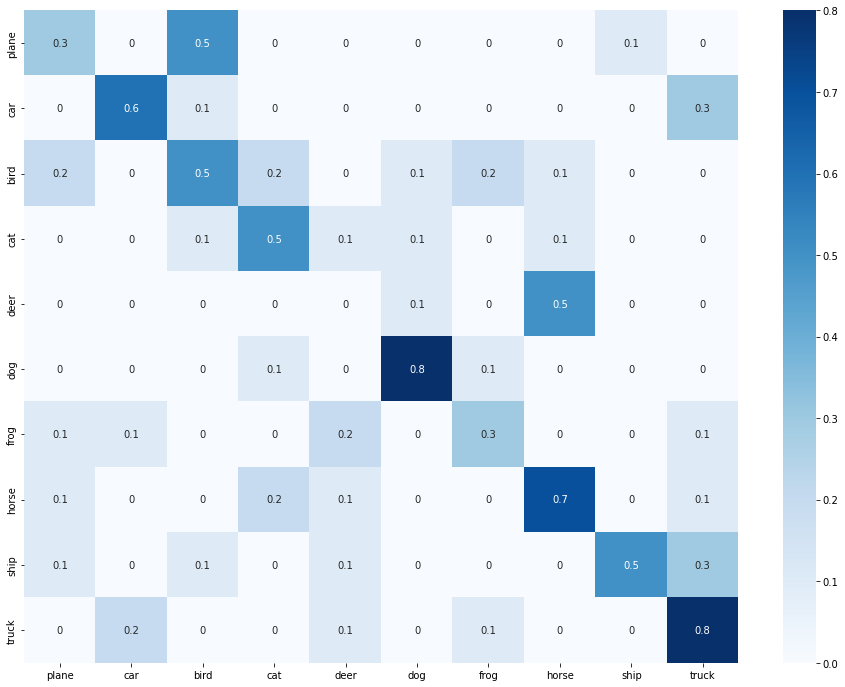

In [19]:
#for firstly trained ResNet18, this before all so I will use targets_18 and predicted_18 as targets and predicted

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


# constant for classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(targets_18.cpu(), predicted_18.cpu())
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (16, 12))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

Above we can see a confusion matrix for before trained ResNet18 model. As we can see, model was quite sure while classifying trucks and dogs, what is a bit surprising, as I thought, that it will missclassify mostly cats and dogs. What is interesting, planes were mostly classified as birds, not planes. Also interesting is, that for this net it was really hard to learn to classify deer as deer - mostly it classified them as horses. However, the images have the resolution of 32x32 pixels, and as we saw before, that means, sometimes it is really hard even for human, to recognize something on the picture. And after all deers and horses are similar... ;)

### Images with misclassification

In *targets_18* I have labels for images that were used for testing on trained ResNet18 model, *inputs_18* are those images. *predicted_18* are labels predicted by the model.

In [24]:
y_true_test=targets_18.cpu().numpy()
y_pred_test=predicted_18.cpu().numpy()

In [25]:
y_true_test

array([2, 0, 8, 9, 9, 4, 7, 8, 4, 2, 1, 2, 8, 0, 9, 3, 9, 7, 7, 1, 2, 7,
       7, 1, 1, 5, 1, 5, 4, 0, 2, 8, 3, 6, 8, 2, 6, 5, 1, 3, 7, 3, 5, 1,
       5, 0, 0, 5, 8, 2, 3, 9, 6, 7, 6, 3, 2, 0, 5, 9, 3, 4, 2, 1, 9, 1,
       7, 7, 0, 6, 9, 9, 8, 0, 8, 4, 6, 3, 6, 8, 7, 1, 5, 9, 8, 2, 0, 3,
       8, 2, 5, 5, 9, 6, 2, 7, 9, 2, 4, 7])

In [26]:
y_pred_test

array([3, 0, 8, 9, 9, 7, 7, 1, 7, 6, 9, 6, 8, 8, 1, 2, 9, 7, 7, 1, 0, 7,
       7, 1, 1, 5, 1, 5, 7, 8, 4, 8, 3, 5, 9, 0, 1, 5, 4, 1, 0, 2, 5, 1,
       4, 0, 4, 5, 9, 2, 3, 8, 6, 9, 6, 2, 3, 0, 5, 4, 3, 1, 3, 1, 9, 8,
       7, 3, 0, 9, 1, 9, 8, 0, 8, 4, 6, 7, 4, 8, 7, 1, 3, 9, 9, 0, 4, 3,
       8, 4, 5, 5, 9, 1, 5, 4, 9, 7, 4, 7])

As we can see, there are some differences between true and predicted labels.

In [27]:
y_true_test==y_pred_test

array([False,  True,  True,  True,  True, False,  True, False, False,
       False, False, False,  True, False, False, False,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True,  True, False, False, False,
       False,  True, False, False, False, False,  True,  True, False,
        True, False,  True, False,  True,  True, False,  True, False,
        True, False, False,  True,  True, False,  True, False, False,
        True,  True, False,  True, False,  True, False, False,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True, False,  True, False, False, False,  True,  True, False,
        True,  True,  True, False, False, False,  True, False,  True,
        True])

Let's see some of the missclassified images, if they look really missleading or the model just did not learn carefully.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
true label: bird
true label: cat


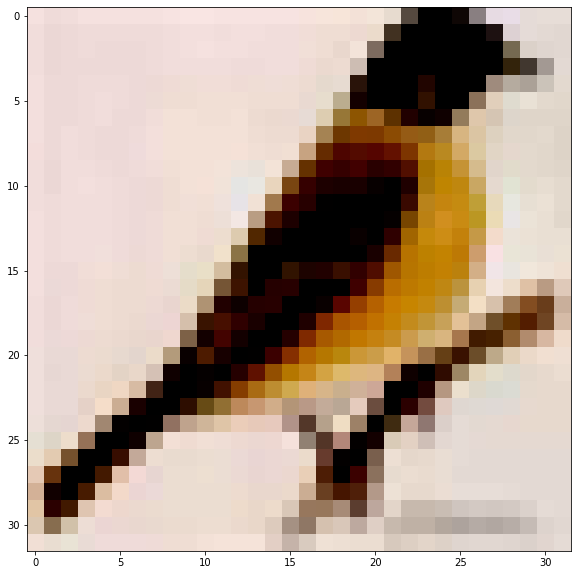

In [45]:
print(type(inputs_18[1]))

grid_test = torchvision.utils.make_grid(inputs_18[0], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[targets_18[0]]}')
print(f'true label: {classes[predicted_18[0]]}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
true label: deer
true label: horse


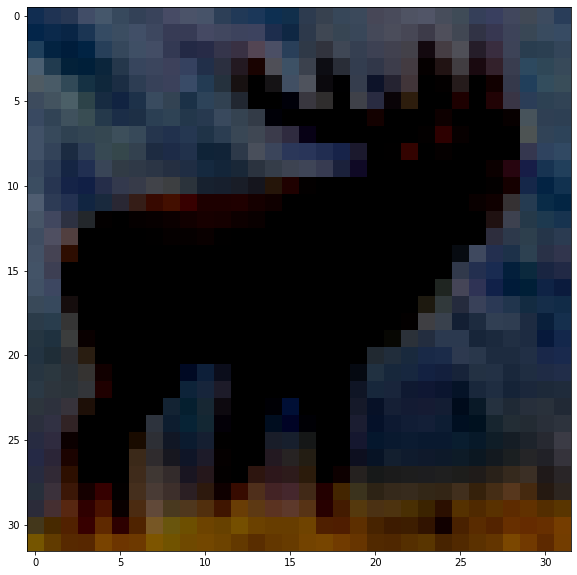

In [46]:
print(type(inputs_18[1]))

grid_test = torchvision.utils.make_grid(inputs_18[5], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[targets_18[5]]}')
print(f'true label: {classes[predicted_18[5]]}')

The first one for me looks really like the bird, so the model just didn't do its work and classify it as a cat - I have no clue, where this bird is similar to a cat, but maybe this is because of colors on that image?

For the second one, I would also have problems with saying, that this is deer, at the beginning I also thought it's a horse. The colors of this photo are not helping with recognizing what is this animal - they are too dark.

Below I also added an images, that is correctly classified by a model. I personally wouldn;t say, in this resolution, that this is a plane, but the model did a good job with classifying it correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
true label: plane
true label: plane


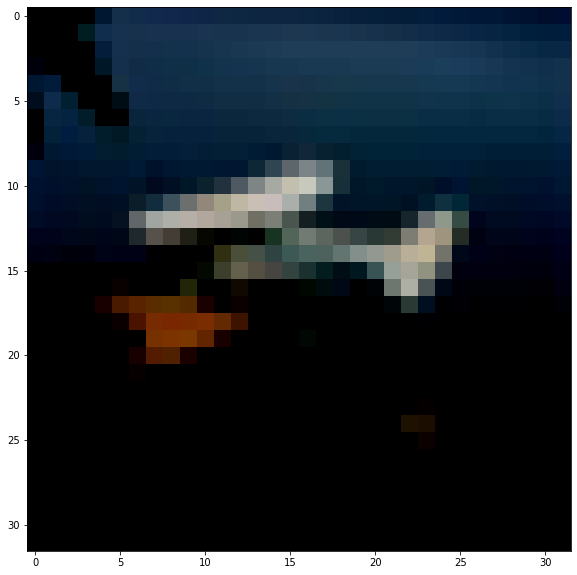

In [47]:
print(type(inputs_18[1]))

grid_test = torchvision.utils.make_grid(inputs_18[1], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[targets_18[1]]}')
print(f'true label: {classes[predicted_18[1]]}')

### Summary

Above nets were trained only on subset of the data. In that case I think, that the results for some of them (of course not the one with dropout) are quite impressive, as taking subset was not balanced in any way. It was cool to see difficlut images (as a plane above), to be correctly classified by a net.

Unfortunatelly, no experiments were conducted on whole dataset, only on 10% of the data, as even with this small part, I had problems with GPU on colab - it said I had used too much of it, and had to switch Gmail accounts :D


During work on this homework, I used:
- https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html
- https://medium.com/@pslinge144/representation-learning-cifar-10-23b0d9833c40
- https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
- https://discuss.pytorch.org/t/where-and-how-to-add-dropout-in-resnet18/12869/2
- https://saptarshidatta.in/2020/10/05/PyTorch_CIFAR10.html